In [4]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn.functional as F

In [5]:
def f(x):
  return 3*x**2 - 4*x + 5

In [6]:
f(3.0)

20.0

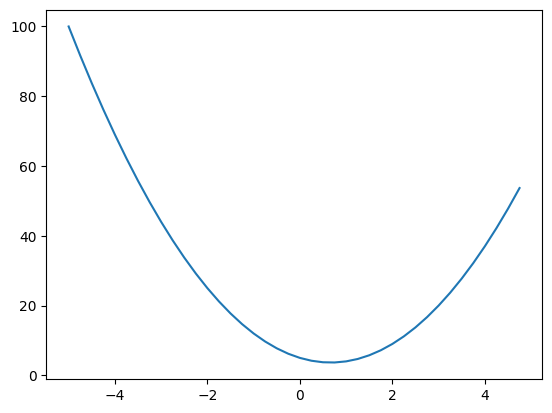

In [7]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [8]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [9]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [10]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)


d1 4.0
d2 4.0001
slope 0.9999999999976694


In [11]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



In [60]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [13]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

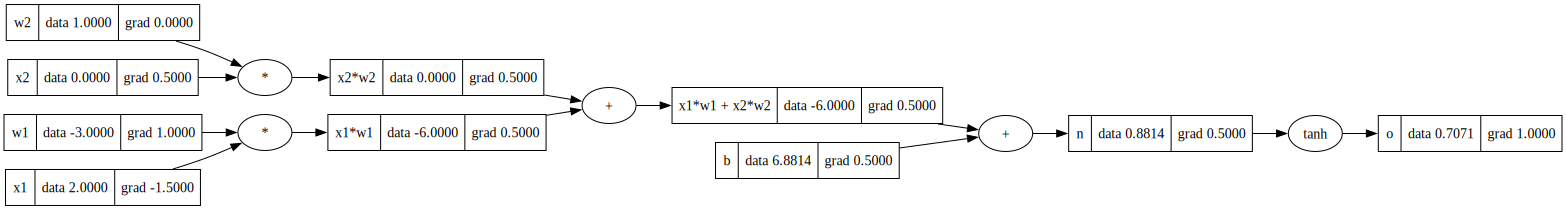

In [14]:
draw_dot(o)

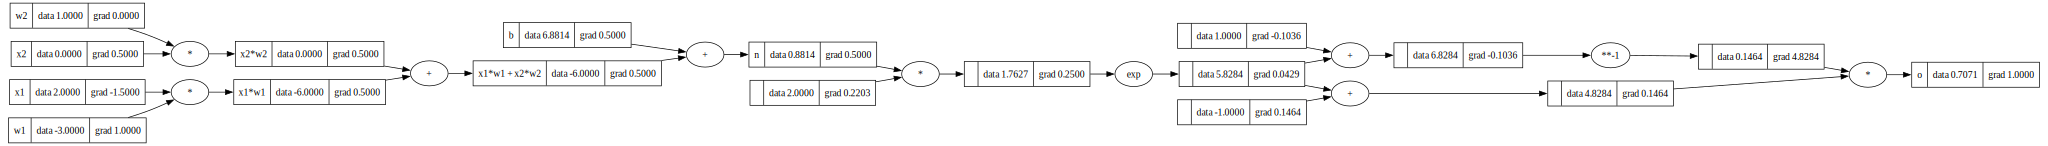

In [15]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [23]:
#One neuron Design
class Neuron:
    def __init__(self, nin):
        #weights (w) bias(b)
        # see below cell for how b and w works
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] 
        #basically two neurons .. if we enter 4 , the model is going to have 4 neurons... 
        
        self.b = Value(random.uniform(-1,1)) #controls the overall trigger happiness of the neuron
        
    def __call__(self, x):
        #x*w +b
       act = sum((wi*xi for wi, xi in zip(self.w,x)), self.b) #initializing at b
       out = act.tanh() #non linearity
       return out
        
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=0.8966984639277646)

In [24]:
# for 4 different neurons 4 weights(w) generated at random... 
#everytime the output will be different
nin =4
w = [Value(random.uniform(-1,1)) for _ in range(nin)] # list of random number for every elements in input
# w is on
b= Value(random.uniform(-1,1))
b, w 


(Value(data=0.8147091414429908),
 [Value(data=-0.9552470896322112),
  Value(data=-0.9013283490718369),
  Value(data=-0.7310232404963495),
  Value(data=-0.36637827963720504)])

<h2> Understanding a neuron</h2>

In [40]:
#Understanding what a neuron is

class Neuron:
    def __init__(self, nin):
        # for every inputs seperate weights must be assigned...
        #so a list of weights at random is created based on the input length
        self.weights = [Value(random.uniform(-1,1)) for _ in range(nin)] 
        # inputs * weights
        #sum( inputs * weights)
        self.bias = Value(random.uniform(-1,1))
        # the product of inputs and weights are then added together
        # and on the result bias is added...
    def __call__(self, x):
        # w * x +b , we need this
        
        act =  sum((wi*xi for wi, xi in zip(self.weights,x)), self.bias)
        out = act.tanh() #hidden layer
        return out
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=0.1776027441656478)

In [96]:
# A layer of neuron design
class Neuron:
    def __init__(self, nin):
        self.w =[Value(random.uniform(-1,1)) for _ in range(nin)] 
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self,x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs
    
x = [2.0, 3.0]
n = Layer(2,3)
n(x)



[Value(data=0.8637483121581138),
 Value(data=0.6924255009509956),
 Value(data=-0.9366207013212905)]

In [58]:
# A layer of neuron design
class Neuron:
    def __init__(self, nin):
        self.w =[Value(random.uniform(-1,1)) for _ in range(nin)] 
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self,x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] +nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    
x = [2.0, 3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=-0.836591764000031)

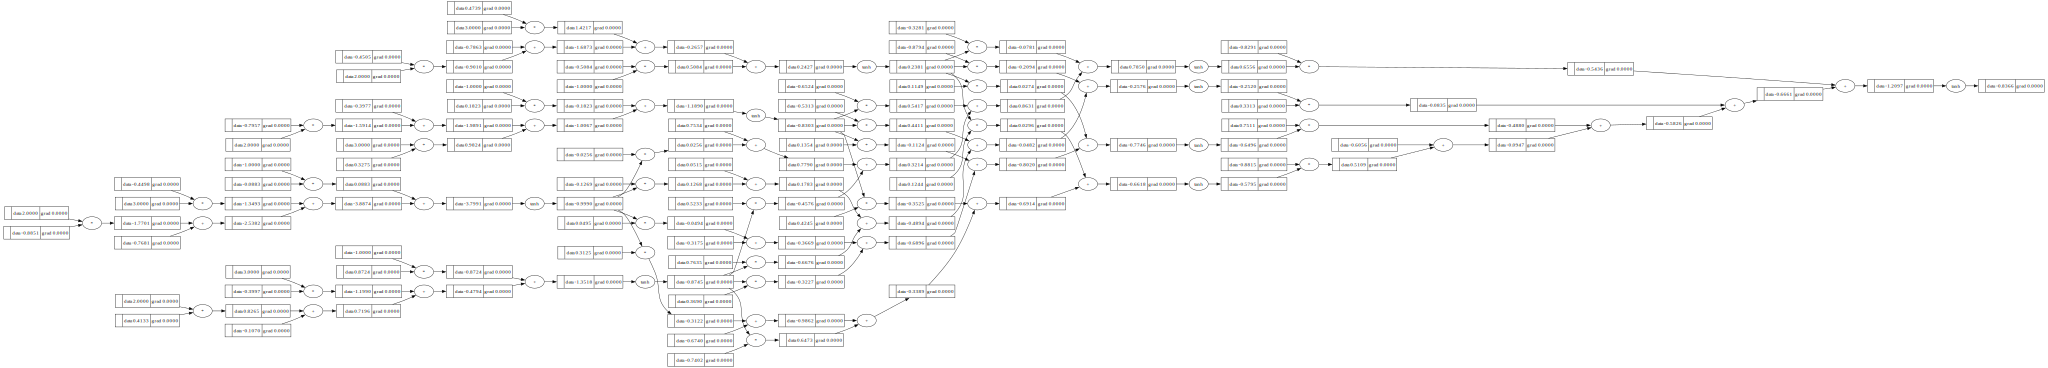

In [61]:
draw_dot(n(x))

In [62]:

[Value(random.uniform(-1,1)) for _ in range(2)]

[Value(data=0.34790164360872144), Value(data=0.33769185361847565)]

In [63]:
Value(random.uniform(-1,1))

Value(data=-0.42146091508767625)

In [85]:
#How to get better result with your neural networ: 
# => Loss function

import torch

In [20]:

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [81]:

class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]
  """
  actual version of above coding
    params = []
    for neuron in self.neurons:
      ps = neuron.parameters()
      params.extend(ps)
    return params
    
    
    """

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [86]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.7657553466387371)

In [87]:
n.parameters()
#weights and biases under the neural networks


[Value(data=-0.44550423690194996),
 Value(data=-0.08693775262177983),
 Value(data=-0.2684158379066204),
 Value(data=-0.6255678983720958),
 Value(data=0.9355837460374248),
 Value(data=-0.6193381031846656),
 Value(data=0.9157168290912776),
 Value(data=0.513206458474107),
 Value(data=0.8573427643520988),
 Value(data=-0.20274320024960146),
 Value(data=0.2994950735532318),
 Value(data=-0.02195190278914283),
 Value(data=-0.9859411684746002),
 Value(data=-0.39748772112145736),
 Value(data=-0.232110794957044),
 Value(data=0.25937557572588776),
 Value(data=-0.17463645293574026),
 Value(data=-0.41101380794826015),
 Value(data=0.9191756441373113),
 Value(data=0.8950804515765616),
 Value(data=0.45972412981489463),
 Value(data=-0.7821080135325396),
 Value(data=-0.5789995153473046),
 Value(data=0.4909793405843397),
 Value(data=0.4657132865282392),
 Value(data=-0.7311068692466027),
 Value(data=0.48022899716428324),
 Value(data=-0.9285712973872933),
 Value(data=-0.24662494506842125),
 Value(data=-0.14

In [90]:
len(n.parameters())
#in total the mlp has 41 parameters


41

In [103]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
#pushing into our neural net
ypred = [n(x) for x in xs]
ypred
#result seem way off our desired targets



[Value(data=0.7644219038233936),
 Value(data=0.8706423102188323),
 Value(data=0.8679849009696309),
 Value(data=0.8220223718613737)]

In [69]:
#Calculating loss 
#ys is our expected result
# ypred is predicted model
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]

[Value(data=3.373069307592746),
 Value(data=0.3621091640006292),
 Value(data=0.31382287960526983),
 Value(data=3.1916436185666726)]

In [137]:
# So the final loss would be the sum of above loss values
ypred = [n(x) for x in xs]
loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=7.115637551011459)

In [138]:

# now we wanna minimize the loss 
loss.backward()

#this gives grad for below cell

In [126]:
# layers ko neurons ko weights
n.layers[0].neurons[0].w[0].grad

#very very important

#now there is gradient on the particular layer of neural network, we see it influence the loss
# if we slightly decrease the weight of the loss
# and we have this information for every neurons
# by decreasing the weight assigened to every neurons  

0.4764342208314879

In [127]:
#value of neurons
n.layers[0].neurons[0].w[0].data

-0.5827453626928276

In [136]:
for p in n.parameters():
    p.data += -0.1*p.grad

In [139]:
ypred

[Value(data=-0.8767893084200126),
 Value(data=-0.9999895191286434),
 Value(data=-0.9086384270082198),
 Value(data=-0.8933970808265255)]

In [ ]:
#Convinient code to gather all the parameters of the neural net so that we operate on them simultaneously

#We can nudge them the tiny about based on the gradient information



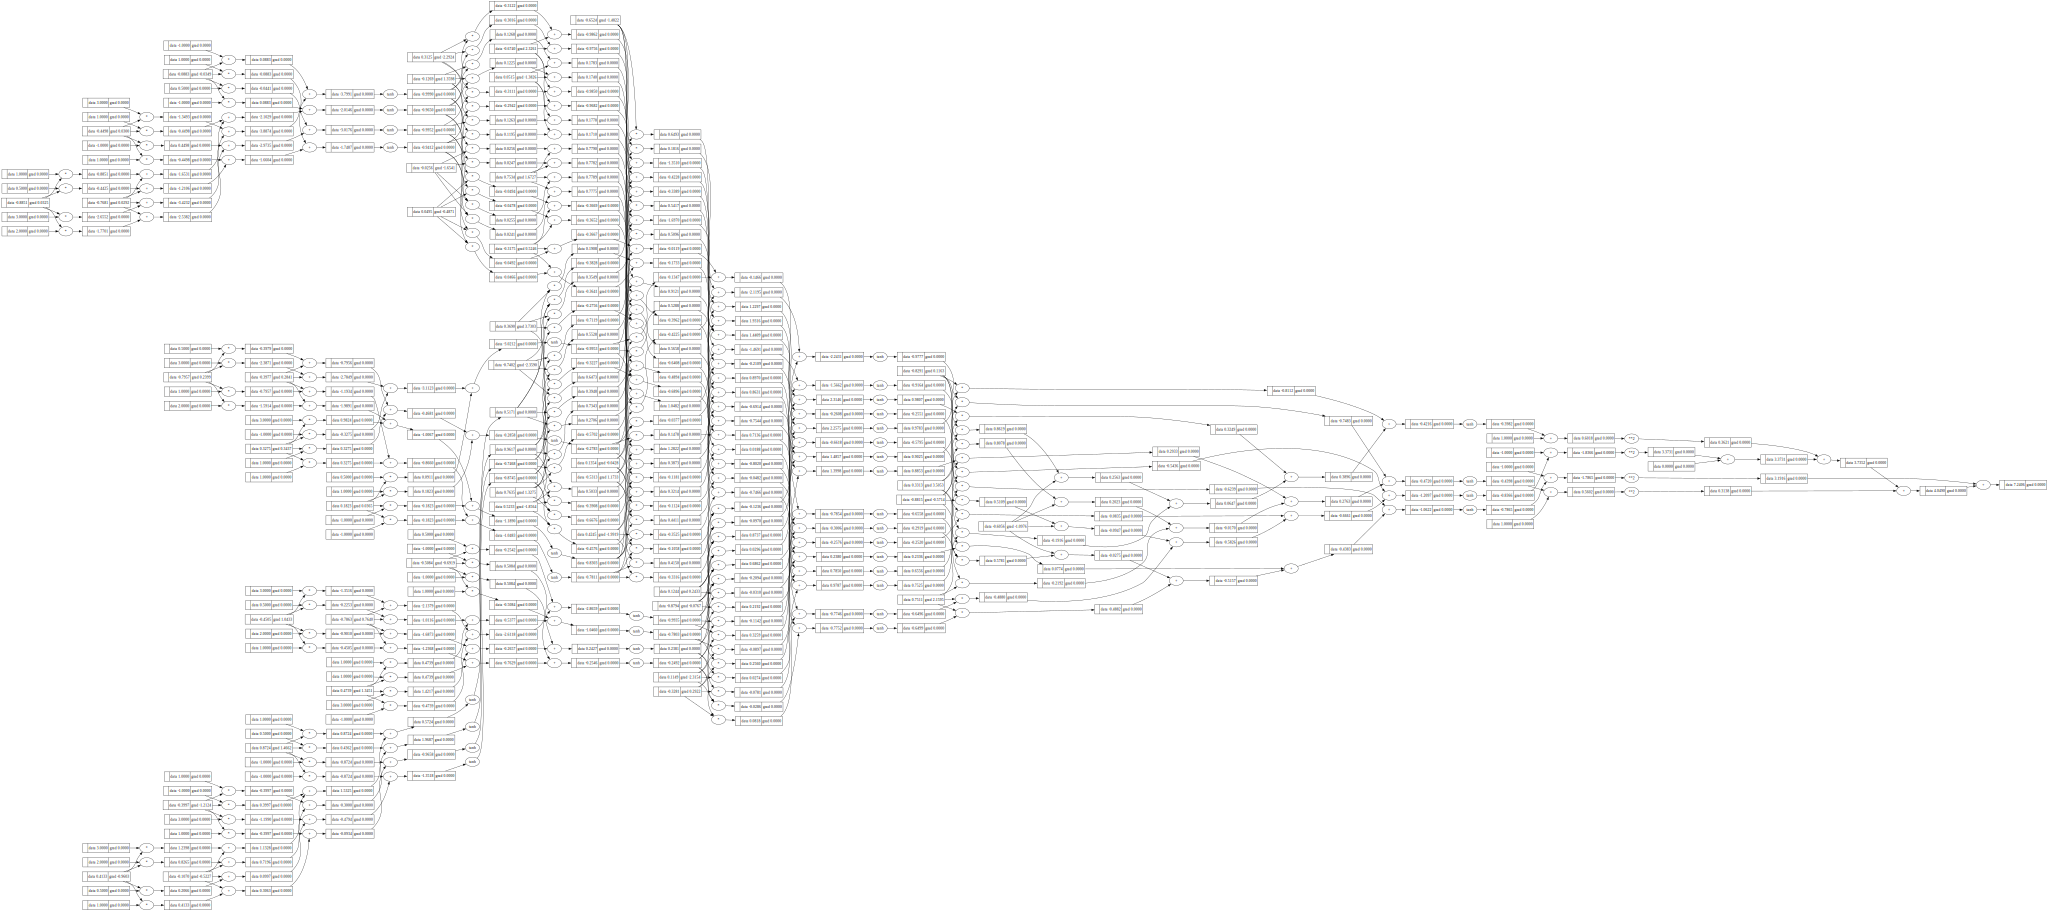

In [82]:
draw_dot(loss)

<h2>Over all summary</h2>

In [142]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [153]:

for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.05 * p.grad
  
  print(k, loss.data)
  

0 0.011923579163845784
1 0.010877782459679373
2 0.009999385022743308
3 0.009251663250526627
4 0.008607803543741993
5 0.008047794466509018
6 0.007556412892497947
7 0.007121881810543613
8 0.006734953341688093
9 0.006388268342547796
10 0.0060759003105563345
11 0.0057930247783124535
12 0.0055356758294016475
13 0.005300564172251726
14 0.0050849394107382795
15 0.004886484513427624
16 0.004703234056520631
17 0.004533510237392936
18 0.004375872323221888
19 0.004229076364290135


In [154]:
ypred

[Value(data=0.96165828691597),
 Value(data=-0.9999880523472071),
 Value(data=-0.9655266518467815),
 Value(data=0.9603694874316185)]